# Quantum Computing: Lab 4

## QFT - Quantum Fourier Transform

You have seen QFT already in the lecture. Today, we want to implement it.

![](resources/qft_algo.png)

We will use the controlled version of the [PhaseGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html), the [CPhaseGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CPhaseGate.html#qiskit.circuit.library.CPhaseGate), which we can apply using the method [cp](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.cp).



In [1]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.circuit.library import TGate
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

import numpy as np
import math

**Exercise:** Implement a method, which creates a QFT circuit for n qubits. Since the regular QFT circuit switches the sequence of the qubits, we want to use SWAP gates to restore the sequence. Use the Pseudocode below, to implement the method.

Pseudocode:

    Algorithm qft(n)

    INPUT: n...Number of Qubits
    OUTPUT: QFT QuantumCircuit for n qubits
    
    circ := QuantumCircuit with n qubits

    for i = 0 to n - 1 do
        circ.h(i)
        
        k := 2
        
        for z = i + 1 to n - 1 do
            circ.cp((2 * np.pi) / 2**k, z, i)
            
            k := k+1
        
    for i = 0 to ⌊n/2⌋ - 1 do
        circ.swap(i, n - i - 1)

    return circ

In [2]:
def qft(n):
    circ = QuantumCircuit(n)
    
    for i in range(n): # 0 - 2
        circ.h(i)
                
        k = 2
        for z in range(i + 1, n): # 1 - 2
            circ.cp((2 * np.pi) / 2**k, z, i)
            k = k + 1
            
    for i in range(math.floor(n/2)):
        circ.swap(i, n - i - 1)
    
    return circ

Compare the output below with the circuit at the top, does it seems right?

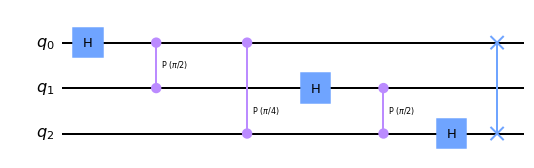

In [3]:
qft(3).draw('mpl')

**Exercise:** What is the QFT circuit for 1 qubit?

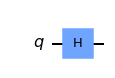

In [4]:
qft(1).draw('mpl')

In the following, we want to apply QFT on different States. The first one is the state $|000\rangle$. Notice, with the bloch multivector we receive qubit 0 to qubit n from left to right.

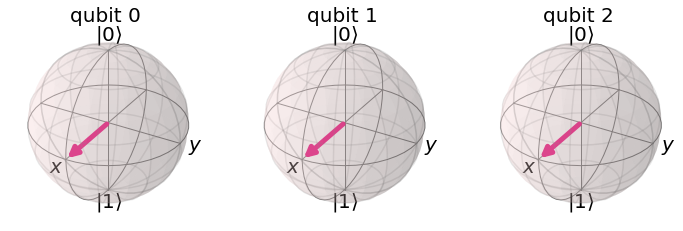

In [5]:
circ_000 = QuantumCircuit(3)
circ_000.append(qft(3), range(3))

plot_bloch_multivector(Statevector.from_instruction(circ_000).data)

__Exercise:__ Apply QFT on the state $|001\rangle$.

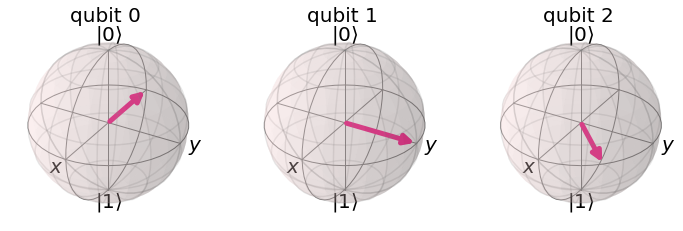

In [6]:
circ_001 = QuantumCircuit(3)
circ_001.x(2)
circ_001.append(qft(3), range(3))

plot_bloch_multivector(Statevector.from_instruction(circ_001).data)

__Exercise:__ Apply QFT on the state $|010\rangle$.

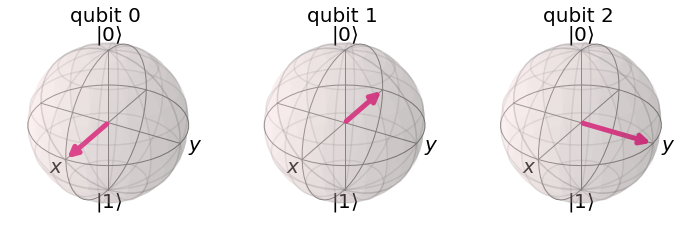

In [7]:
circ_010 = QuantumCircuit(3)
circ_010.x(1)

circ_010.append(qft(3), range(3))

plot_bloch_multivector(Statevector.from_instruction(circ_010).data)

__Exercise:__ Apply QFT on the state $|011\rangle$.

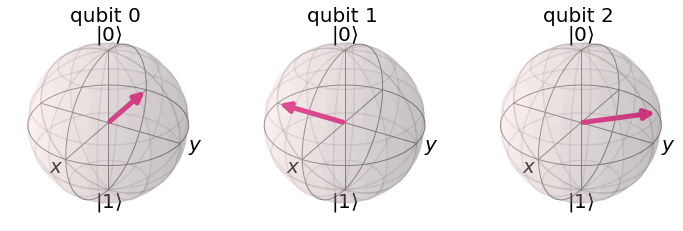

In [8]:
circ_011 = QuantumCircuit(3)
circ_011.x(1)
circ_011.x(2)
circ_011.append(qft(3), range(3))

plot_bloch_multivector(Statevector.from_instruction(circ_011).data)

__Exercise:__ Compare the bloch multivectors, what do you notice?

In [9]:
qft_3_inverse = qft(3).to_gate().inverse()

__Exercise:__ Apply QFT on the state $|011\rangle$ and then the inverse QFT, wich I created above.

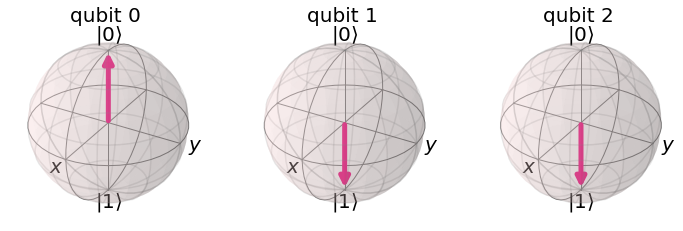

In [10]:
circ_011_reverse = QuantumCircuit(3)
circ_011_reverse.x(1)
circ_011_reverse.x(2)
circ_011_reverse.append(qft(3), range(3))
circ_011_reverse.append(qft_3_inverse, range(3))

plot_bloch_multivector(Statevector.from_instruction(circ_011_reverse).data)

## QPE - Quantum Phase Estimation

You haven't seen QPE in the lecture. However, Shor is practically a QPE algorithm, so we will introduce it here.

![](resources/qpe_algo.png)

QPE will turn $U|\psi\rangle = e^{i\theta_{\psi}}|\psi\rangle$ or more precisely $U|\psi\rangle = e^{2\pi{}i\theta_{\psi}}|\psi\rangle$ into $|2^n\theta\rangle$. This means if we have a unitary gate which acts on a state $|\psi\rangle$, we can estimate the global phase, which is added thorugh the gate. For this algorithm we only need a conrtrolled version of the untiary gate and inverse QFT. The result is stored in $n$ "counting qubits". If the phase can be described as an integer with the number of qubits, we obtain an exact solution. However, if we could represent the phase only as an floating point number with the number of "counting qubits", we get only an approximation. 

Notice, that the gate $U_f^{2^n-1}$ means, that we apply the $U_f$ gate $2^{n-1}$ times. This is done, because we have to convert from integers to binary numbers.

In the following we will analyse the [TGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TGate.html) using QPE. This gate adds to the $|1\rangle$ state a phase of $e^{i\pi/4}$ or rather $e^{i2\pi/8}$, if we correct for the $2\pi$ in QPE. Thus, we expect to receive $\frac{1}{8}$ for $\theta$.

In [11]:
controlled_tgate = TGate().control()

__Exercise:__ Create the circuit QPE circuit for one counting qubit and $|\psi\rangle$ in state $|1\rangle$. (We need the controlled T gate $2^0$ times)

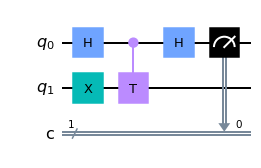

In [12]:
circ = QuantumCircuit(2, 1)

circ.h(0)
circ.x(1)

circ.append(controlled_tgate, [0, 1])

circ.h(0)

circ.measure(0, 0)

circ.draw('mpl')

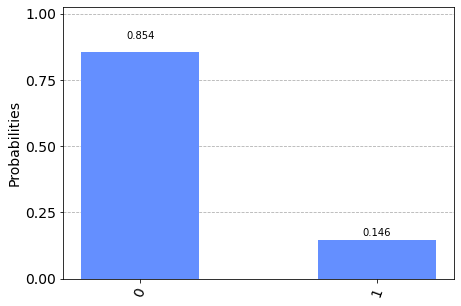

In [13]:
job = execute(circ, BasicAer.get_backend('qasm_simulator'), shots=8096)
plot_histogram(job.result().get_counts())

__Exercise:__ Since 1 qubit is not sufficient for the phase, we need to implement the circuit with 3 counting qubits. (The inverse QFT for 3 qubits was already created above). Compare the circuit with the schematic above.

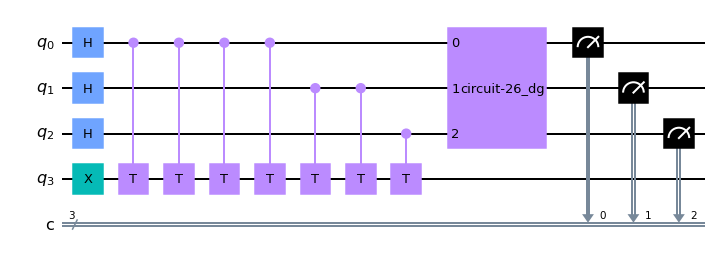

In [14]:
circ = QuantumCircuit(4, 3)

circ.h(range(3))
circ.x(3)

for i in range(4):
    circ.append(controlled_tgate, [0, 3])

for i in range(2):
    circ.append(controlled_tgate, [1, 3])

circ.append(controlled_tgate, [2, 3])
    
circ.append(qft_3_inverse, range(3))

circ.measure(range(3), range(3))

circ.draw('mpl')

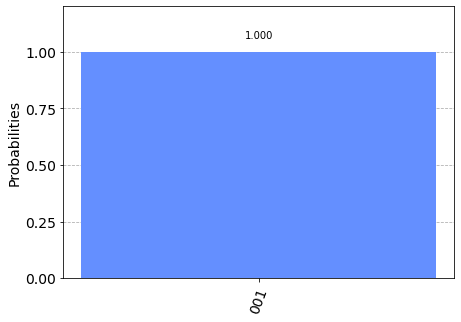

In [15]:
job = execute(circ.reverse_bits(), BasicAer.get_backend('qasm_simulator'), shots=8096)
plot_histogram(job.result().get_counts())

You should have received the state $|001\rangle$, which leaves us with the following phase: $2^3\theta = 1 \Rightarrow \theta = 1/2^3 = 1/8$.

## Shor

You have already seen an implementation of Shor in the lecture. In this lab we want to implement Shor in a different way, which shows its relation to QPE even better. However, instead of implementing $a^x mod N$ as $|x\rangle|0\rangle \rightarrow |x\rangle|0 \oplus a^x mod N\rangle$ we now implement it as $|x\rangle|1\rangle \rightarrow |x\rangle|1 * a^x mod N\rangle$. See the schematic of the circuit below and compare it with QPE!

![](resources/shor_algo.png)

Implementing the funciton $a^x mod N$ is quite tricky. Thus, I have implemented the $2 mod 15$ gate for the $2^0$ case here. Remember from the QPE section, that for the $2^{n-1}$ case, we just need to apply the gate $2^{n-1}$ times.

In [16]:
circ_2_mod_15 = QuantumCircuit(4)

circ_2_mod_15.swap(0, 1)
circ_2_mod_15.swap(1, 2)
circ_2_mod_15.swap(2, 3)

controlled_2_mod_15 = circ_2_mod_15.to_gate(label='2^x mod 15').control()

__Exercise:__ Implement the quantum part of Shor for $a = 2$ and $N = 15$. We need this time 4 counting qubits and 4 qubits for $|y\rangle$, which starts in the state $|1\rangle$ (this is already prepared for you).

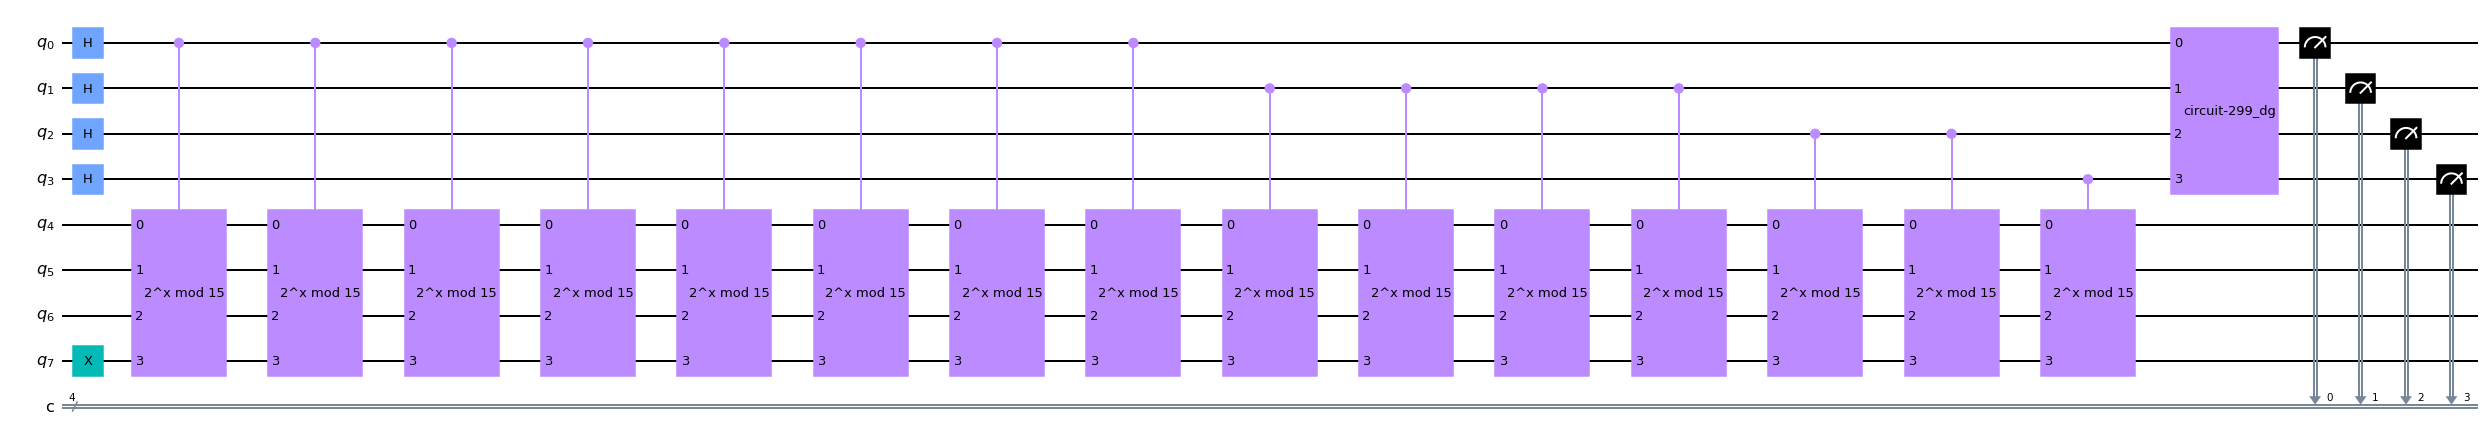

In [17]:
circ = QuantumCircuit(8, 4)

circ.h(range(4))

circ.x(7)

for i in range(8):
    circ.append(controlled_2_mod_15, [0, 4, 5, 6, 7])
    
for i in range(4):
    circ.append(controlled_2_mod_15, [1, 4, 5, 6, 7])
    
for i in range(2):
    circ.append(controlled_2_mod_15, [2, 4, 5, 6, 7])
    
for i in range(1):
    circ.append(controlled_2_mod_15, [3, 4, 5, 6, 7])
    
circ.append(qft(4).to_gate().inverse(), range(4))

circ.measure(range(4), range(4))

circ.draw('mpl', fold=-1)

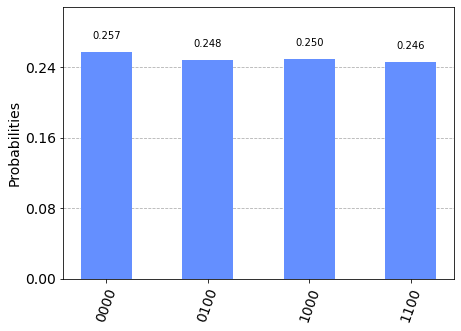

In [18]:
job = execute(circ.reverse_bits(), BasicAer.get_backend('qasm_simulator'), shots=8096)
plot_histogram(job.result().get_counts())

In [19]:
job.result().get_counts()

{'0000': 2078, '1100': 1988, '0100': 2010, '1000': 2020}

In [20]:
for bin_str in job.result().get_counts().keys():
    print(int(bin_str, 2))

0
12
4
8


We have received the 4 results above. Remember Shor expects us to run the circuit only once. Thus, we would have received only one of the 4 results.

__Exercise:__ Calculate the classical part for Shor for each of the 4 results on paper to reveal the prime factors of $N=15$.